# Avito: O que é? 

# Importando libs

In [61]:
%matplotlib inline  
import gc
import re

import nltk
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import scipy as sp
from scipy.sparse import hstack, csr_matrix


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import FeatureUnion
from rake_nltk import Rake

from helpers import save_model, load_model, limit_value


nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Carregando o dataset

In [2]:
_train_complete_df = pd.read_csv('train.csv.zip', compression='zip', index_col = "item_id")
train_complete_df = _train_complete_df.copy()

In [3]:
_submission_df = pd.read_csv('test.csv.zip', compression='zip', index_col = "item_id")
submission_df = _submission_df.copy()

In [4]:
train_complete_index = train_complete_df.index
submission_index = submission_df.index

y = train_complete_df['deal_probability'].copy()
train_complete_df.drop("deal_probability",axis=1, inplace=True)

In [5]:
full_df = pd.concat([train_complete_df,submission_df], axis=0)
del train_complete_df, submission_df

In [6]:
def apply_uppercases_and_num_words(df, col_name):
    uppercases = []
    perc_uppercases = []
    total_num_words = []
    for text in df[col_name]:
        text = str(text)
        # remove numeros
        text = re.sub('[0-9]+', '', text)
        
        total_uppers = sum(1 for c in text if c.isupper())
        uppercases.append(total_uppers)
        total = len(text)
        if total == 0:
            perc = 0.0
        else:
            perc = total_uppers/total
        num_words = len(text.split(' '))
        total_num_words.append(num_words)

        perc_uppercases.append(perc)
    
    df[f'perc_uppercases_{col_name}'] = perc_uppercases
    df[f'num_words_{col_name}'] = total_num_words
    return df

In [25]:
# transformando descrições nulas em str vazias
full_df['description'] = full_df['description'].replace(np.nan, '', regex=True)


In [7]:
full_df['price'] = np.log(full_df['price']+0.001)
full_df['price'].fillna(-999,inplace=True)
full_df['image_top_1'].fillna(-999,inplace=True)

In [8]:
label_encoder = preprocessing.LabelEncoder()
cat_features = [
    'image_top_1',
    'city',
    'region',
    'parent_category_name',
    'category_name',
    'user_type',
    'param_1'
]
for feature_name in cat_features:
    print(f'encode {feature_name}')
    full_df[feature_name] = label_encoder.fit_transform(full_df[feature_name].astype(str))
    

encode image_top_1
encode city
encode region
encode parent_category_name
encode category_name
encode user_type
encode param_1


In [9]:
full_df = apply_uppercases_and_num_words(full_df, 'description')
full_df = apply_uppercases_and_num_words(full_df, 'title')

In [34]:
def return_text_cols_reduced(df):
    # Uses stopwords for russian from NLTK, and all puntuation characters.
    r = Rake(language='russian')
    
    total = df['description'].shape[0]
    
    verbose_step_size = int(total/10)
    description_reduced = []
    for i, description in enumerate(df['description']):
        r.extract_keywords_from_text(description)
        phrases_and_scores = r.get_ranked_phrases_with_scores()  
        if len(phrases_and_scores) <= 1:
            description_reduced.append(description)
            continue
        mean_score = np.mean([x[0] for x in phrases_and_scores])

        highest_phrases = [x[1] for x in phrases_and_scores if x[0] >= mean_score]
        reduced_description = ' '.join(highest_phrases)
        description_reduced.append(reduced_description)
        
        if i % verbose_step_size == 0:
            print(f'{int(i/total*100)}') 
        
    return description_reduced



In [35]:
full_df['description_reduced'] = return_text_cols_reduced(full_df)

0
9
19
29
39
49
69
79
89
99


In [ ]:
# def prepare_vectorizer_and_col(df, col_name):
#     vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('russian'))
#     corpus = df[col_name]
#     col_vectorized = vectorizer.fit_transform(corpus)
#     return col_vectorized, vectorizer

def transform_tfidf(col_vectorized):
    tfidf_transformer = TfidfTransformer()
    tfidf_mat = tfidf_transformer.fit_transform(vectorized_col)
    return tfidf_mat, tfidf_transformer


def vectorized_texts(df):
stop_words = stopwords.words('russian')

tfidf_params = {
    "token_pattern": r'\w{1,}',
    "analyzer": 'word',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    "stop_words": stop_words,
    "smooth_idf":False
}

vectorizer = FeatureUnion([
    ('description_reduced',TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=16000,
        **tfidf_params,
        preprocessor=lambda x: x['description_reduced'])),
    ('title',TfidfVectorizer(
        ngram_range=(1, 2),
        **tfidf_params,
        #max_features=7000,
        preprocessor=lambda x: x['title']))
])

text_transformed = vectorizer.transform(df[['description_reduced', 'tittle']].to_dict('records'))
tfidf_features_name = vectorizer.get_feature_names()
    

In [37]:

stop_words = stopwords.words('russian')

tfidf_params = {
    "token_pattern": r'\w{1,}',
    "analyzer": 'word',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    "stop_words": stop_words,
    "smooth_idf":False
}

vectorizer = FeatureUnion([
    ('description_reduced',TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=16000,
        **tfidf_params,
        preprocessor=lambda x: x['description_reduced'])),
    ('title',TfidfVectorizer(
        ngram_range=(1, 2),
        **tfidf_params,
        #max_features=7000,
        preprocessor=lambda x: x['title']))
])


vectorizer.fit(full_df[['description_reduced', 'title']].to_dict('records'))

FeatureUnion(n_jobs=1,
       transformer_list=[('description_reduced', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float32'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=16000, min_df=1,
        ngram_range=(1, 2), norm='l2',
        p...sublinear_tf=True, token_pattern='\\w{1,}',
        tokenizer=None, use_idf=True, vocabulary=None))],
       transformer_weights=None)

In [42]:

text_transformed = vectorizer.transform(full_df.to_dict('records'))
tfidf_features_name = vectorizer.get_feature_names()
    

In [47]:
train_complete_df = full_df.loc[train_complete_index,:].copy()
submission_df = full_df.loc[submission_index,:].copy()

In [22]:
del full_df

In [48]:
gc.collect()

484

In [52]:
train_complete_df['deal_probability'] = y

In [49]:
def get_mean_and_freq(df, col_name):
    group = df[[col_name, 'deal_probability']].groupby(col_name)
    freq = (group['deal_probability'].count()/df.shape[0]).to_dict()
    mean = group['deal_probability'].mean().to_dict()
    return mean, freq

def apply_prob_dict_to_col(df_col, prob_dict):
    return df_col.apply(lambda x: prob_dict.get(x, 0.0))


In [53]:
image_top_mean_dict, image_top_freq_dict = get_mean_and_freq(train_complete_df, 'image_top_1')
city_mean_dict, city_freq_dict = get_mean_and_freq(train_complete_df, 'city')

In [54]:
def add_mean_freq_cols_to_df(df, col_name, mean_dict, freq_dict):
    df[f'{col_name}_mean'] = apply_prob_dict_to_col(
        df[col_name], mean_dict
    )
    df[f'{col_name}_freq'] = apply_prob_dict_to_col(
        df[col_name], freq_dict
    )
    return df


In [55]:
train_complete_df = add_mean_freq_cols_to_df(
    train_complete_df, 'image_top_1', image_top_mean_dict, image_top_freq_dict)

train_complete_df = add_mean_freq_cols_to_df(
    train_complete_df, 'city', city_mean_dict, city_freq_dict)


submission_df = add_mean_freq_cols_to_df(
    submission_df, 'image_top_1', image_top_mean_dict, image_top_freq_dict)

submission_df = add_mean_freq_cols_to_df(
    submission_df, 'city', city_mean_dict, city_freq_dict)

In [56]:
# train_df, test_df = train_test_split(
#     train_complete_df, test_size=0.2, random_state=123654)

In [57]:
gc.collect()

150

In [58]:
# train_df['deal_probability'].hist()


In [59]:
features = [
    'price', 
    'item_seq_number', 
    'image_top_1', 
    'city',
    'region',
    'parent_category_name',
    'category_name',
    'user_type',
    'param_1'
]

# features = [f'image_top_1_{i}' for i in ['mean', 'freq']]
# features.extend([f'city_{i}' for i in ['mean', 'freq']])
features.extend([
    'perc_uppercases_description',
    'perc_uppercases_title',
    'num_words_description',
    'num_words_title',
])


In [62]:
X = hstack([
    csr_matrix(train_complete_df[features].values), 
    text_transformed[0:train_complete_index.shape[0]]
])
submission_X = hstack([csr_matrix(submission_df[features].values), text_transformed[train_complete_index.shape[0]:]])

final_features_list = features + tfidf_features_name

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123654)

## XGBoost Regressor

In [64]:
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgb_reg = XGBRegressor(reg_lambda=0, n_jobs=6)  


In [65]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgb_reg, params, n_jobs=1)  
gs.fit(X_train, y_train) 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3cb9cd67b8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3cb9cdc4a8>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3cb9cdcd68>, 'colsample_bytree...cd6da0>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3cb9cd6da0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
         

In [66]:
print(gs.best_score_)

0.22679774390187796


In [64]:
print(gs.best_score_)

0.13906808430320694


In [67]:
xgb_reg_best = gs.best_estimator_

In [68]:
xgb_reg_best

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8721050591659705, gamma=0.13772475163330578,
       learning_rate=0.15508102986056782, max_delta_step=0, max_depth=36,
       min_child_weight=26.80177238836962, missing=None, n_estimators=30,
       n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=121.54330086419081, reg_lambda=0, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9502235163924858)

In [69]:
# salvando o modelo
save_model('xgb_full_reg_best_rsCV.pkl', xgb_reg_best)

## Usando o Modelo do XGBoost gerado

In [70]:
y_test_predict = xgb_reg_best.predict(X_test)

y_test_predict_treated = np.array(list(map(limit_value, y_test_predict)))


In [71]:
print(mean_squared_error(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict_treated))

0.05179849120888397
0.05179835741089532


In [72]:
print(mean_squared_error(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict_treated))

0.05179849120888397
0.05179835741089532


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c3423dda0>,
      dtype=object)

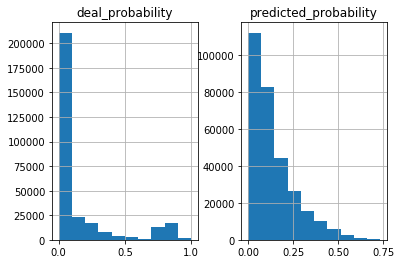

In [73]:
prediction_test_df = pd.DataFrame(
    {'predicted_probability': y_test_predict_treated, 'deal_probability': y_test}, 
#     index=test_df.index
)
prediction_test_df[['predicted_probability', 'deal_probability']].hist()

In [74]:
prediction_test_df.describe()

,predicted_probability,deal_probability
count,300685.000000,300685.000000
mean,0.141679,0.139493
std,0.116530,0.260449
min,0.000000,0.000000
25%,0.053452,0.000000
50%,0.101444,0.000000
75%,0.193051,0.151780
max,0.733150,1.000000


In [75]:
y_submission_predict = xgb_reg_best.predict(submission_X)

In [76]:
y_submission_predict_treated = np.array(list(map(limit_value, y_submission_predict)))

In [77]:
submission_prediction_df = pd.DataFrame(
    {'deal_probability': y_submission_predict_treated}, 
    index=submission_df.index)
submission_prediction_df['deal_probability'].describe()

count    508438.000000
mean          0.150341
std           0.119854
min           0.000000
25%           0.057571
50%           0.110739
75%           0.206599
max           0.723558
Name: deal_probability, dtype: float64

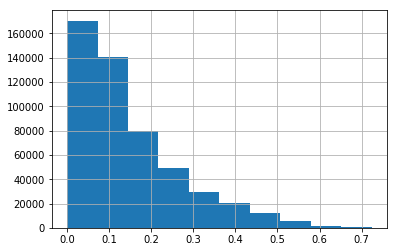

In [78]:
submission_prediction_df['deal_probability'].hist()

In [79]:
assert submission_prediction_df['deal_probability'].min() >= 0
assert submission_prediction_df['deal_probability'].shape[0] == 508438

In [80]:
submission_prediction_df.to_csv('submission_xgb_perc_uppercases_nwords_desc_title_and_almostall_features_no_prob_text_analysis.csv')

In [26]:
caps_in_desc = []
perc_caps_in_desc = []

for desc in df_simple['description']:
    desc = str(desc)
    total_caps = sum(1 for c in desc if c.isupper())
    caps_in_desc.append(total_caps)
    total = len(desc)
    if total == 0:
        perc = 0.0
    else:
        perc = total_caps/total

        
    perc_caps_in_desc.append(perc)

In [30]:
df = df_simple.copy()

In [31]:
df['perc_uppercases_desc'] = perc_caps_in_desc

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc007f6390>,
      dtype=object)

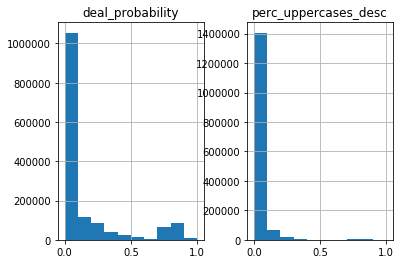

In [43]:
df[['perc_uppercases_desc', 'deal_probability']].hist()

## Tratamento dos dados

In [5]:
# transformando descrições nulas em str vazias
df_simple['description'] = df_simple['description'].replace(np.nan, '', regex=True)


In [6]:

# trocando para que colunas com valores em russo sejam substituidas por valores de 0-N
# acho q isso vai facilitar na hora de acessar essas colunas
# ao inves de tentar pegar pelos diferentes valores de cada uma
def convert_columns_with_russian_values_to_numbers(df, cols):
    transform_dict = {}
    for col in cols:
        cats = pd.Categorical(df[col]).categories
        d = {}
        for i, cat in enumerate(cats):
            d[cat] = f'{i}'
        transform_dict[col] = d
    inverse_transform_dict = {}
    for col, d in transform_dict.items():
        inverse_transform_dict[col] = {v:k for k, v in d.items()}
        
    return df.replace(transform_dict), inverse_transform_dict
# Aplica essa função para category_name e region
df, inverse_transform_dict = convert_columns_with_russian_values_to_numbers(df_simple, ['category_name', 'region'])

# transforma user_type e category_name em diferentes colunas com representações one-hot delas
df = pd.get_dummies(df, columns=['user_type','category_name', ])


In [7]:
# add deal_prob_class (low, average ou high)

def convert_deal_probability_to_class(value):
    classes = [

    ]
    if value * 100 <= (100 / 3 * 1):
        return 'low'
    elif value * 100 <= (100 / 3 * 2):
        return 'average'
    else:
        return 'high'

df['deal_prob_class'] = df['deal_probability'].apply(convert_deal_probability_to_class)

## Train-test split (com amostra)

In [8]:
# train_frac == 0.34 ~= 510000 ~= total de exemplos no test_csv.zip
def get_train_test_samples(df, seed, train_frac=0.34): 
    train_dfs = []
    test_dfs = []
    for klass in ['low', 'average', 'high']:
        klass_df = df[df['deal_prob_class'] == klass]
        klass_train, klass_test = train_test_split(klass_df,  test_size=(1-train_frac), random_state=seed)
        train_dfs.append(klass_train)
        test_dfs.append(klass_test)
        
    train_df = pd.concat(train_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)
    return train_df, test_df

seed = np.random.RandomState(seed=123654)
train_df, test_df = get_train_test_samples(df, seed, train_frac=0.34)

511163

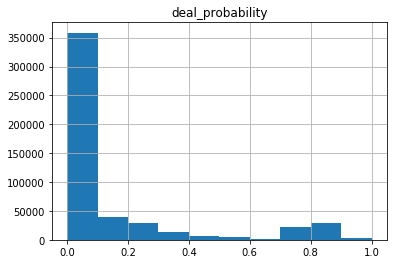

In [9]:
train_df.hist('deal_probability')
train_df.shape[0]

Comparando com o original:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcabb7079e8>]],
      dtype=object)

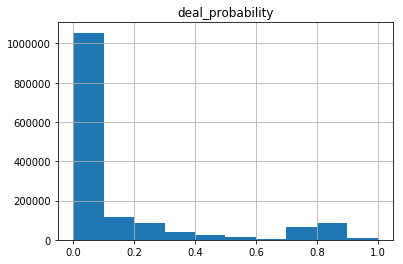

In [12]:
df.hist(column='deal_probability')

## Sobre os dados

* title
* description
* user_type
* price
* category_name
* item_seq_number
* region
* deal_probability


Uma olhada nos dados:

In [4]:
df.head(5)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


Agrupando pelas categorias

In [8]:
group_category = df_simple.groupby('category_name')
group_category.count().head(3)

,item_id,user_id,region,city,parent_category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
category_name,,,,,,,,,,,,,,,,,
Автомобили,62494,62494,62494,62494,62494,62055,62055,61937,62494,62494,61287,62494,62494,62494,58949,58949,62494
Аквариум,4840,4840,4840,4840,4840,0,0,0,4840,4504,4302,4840,4840,4840,4519,4519,4840
Аудио и видео,27036,27036,27036,27036,27036,26857,0,0,27036,24880,26186,27036,27036,27036,25893,25893,27036


Conferindo comportamento de items com preço 0
grande parte é proximo de 0
E alguns tmb são muito vendidos (vi que tem muitas coisas de troca, ou adoção de animal abandonado por exemplo)

(2369, 18)
(2277, 18)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f931a501588>]],
      dtype=object)

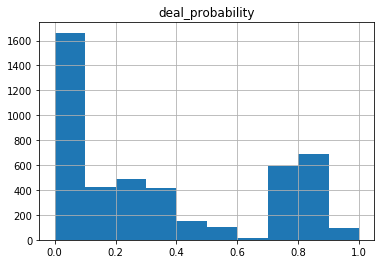

In [6]:
free_price = df[(df['price'] == 0)]
print(free_price[(free_price['deal_probability'] < 0.25)].shape)
print(free_price[(free_price['deal_probability'] >= 0.25)].shape)
free_price.hist(column='deal_probability')

## Visualizando a distribuiçã das probabilidades de venda

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44380074a8>]],
      dtype=object)

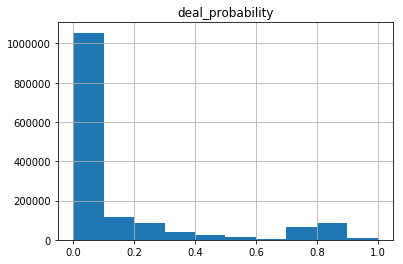

In [10]:
df.hist(column='deal_probability')

# Testando montar um bag of words

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def prepare_vectorizer_and_col(df, col_name):
    vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('russian'))
    corpus = df[col_name]
    col_vectorized = vectorizer.fit_transform(corpus)
    return col_vectorized, vectorizer

    



[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
description_vectorized, vectorizer_description = prepare_vectorizer_and_col(df, 'description')

In [15]:
from sklearn.naive_bayes import MultinomialNB

def get_multinomial_NB(X, y):
    classifier = MultinomialNB()
    classifier.fit(X, y)
    return classifier


In [16]:
model_description_multinomial_nb = get_multinomial_NB(description_vectorized, df['deal_prob_class'])

## testando modelo LinearRegression

In [24]:
from sklearn.linear_model import LinearRegression

# clf.(description_vectorized, df['deal_probability'])
linear_regression = LinearRegression()
linear_regression.fit(description_vectorized, df['deal_probability'])
# clf.predict()


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
import pickle
def save_description_linear_regression_model(pkl_filename, model):
    with open(pkl_filename, 'wb') as f:
        pickle.dump(model, f)
def load_description_linear_regression_model(pkl_filename):
    with open(pkl_filename, 'rb') as f:
        pickle_model = pickle.load(f)
        return pickle_model

In [37]:
save_description_linear_regression_model('description_countvec_lreg_model.pkl', linear_regression)
description_countvec_lreg_model = load_description_linear_regression_model('description_countvec_lreg_model.pkl')

In [ ]:
testv = description_countvec_lreg_model.coef_ == linear_regression.coef_

### Testando o modelo em cima do proprio dataset de treino:

In [53]:
from sklearn.metrics import mean_squared_error
#Bobinho, testando em cima do proprio treino, e ainda assim ficou bem ruim
desc_countvec_lreg_predict = description_countvec_lreg_model.predict(description_vectorized)

mean_squared_error(df['deal_probability'], desc_countvec_lreg_predict)

0.0396135274399414

## Testando usando linear regression + o predict do modelo anterior

primeiro add essa predict do modelo anterior no dataset

In [57]:
df['desc_countvec_lreg_predict'] = desc_countvec_lreg_predict

Agora usar isso e 'user_type, price, category_name, item_seq_number, region' pra 
 fazer uma nova linear regression (só preciso normalizar primeiro e arrumar as colunas que são classes)

# Tudo de novo, mas usando train dataset

In [14]:
from rake_nltk import Rake

def return_description_reduced(df):
    # Uses stopwords for russian from NLTK, and all puntuation characters.
    r = Rake(language='russian')
    
    total = df['description'].shape[0]
    
    verbose_step_size = int(total/10)
    description_reduced = []
    for i, description in enumerate(df['description']):
        r.extract_keywords_from_text(description)
        phrases_and_scores = r.get_ranked_phrases_with_scores()    
        mean_score = np.mean([x[0] for x in phrases_and_scores])

        highest_phrases = [x[1] for x in phrases_and_scores if x[0] >= mean_score]
        reduced_description = ' '.join(highest_phrases)
        description_reduced.append(reduced_description)
        
        
        if i % verbose_step_size == 0:
            print(f'{int(i/total*100)}') 
        
    return description_reduced



[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def prepare_vectorizer_and_col(df, col_name):
    vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('russian'))
    corpus = df[col_name]
    col_vectorized = vectorizer.fit_transform(corpus)
    return col_vectorized, vectorizer


In [11]:
train_df['description_reduced'] = return_description_reduced(train_df)

0.0


/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.09999941310306106
0.1999988262061221
0.2999982393091832
0.3999976524122442
0.4999970655153053
0.5999964786183664
0.6999958917214274
0.7999953048244884
0.8999947179275495
0.9999941310306106


In [15]:
description_vectorized, vectorizer_description = prepare_vectorizer_and_col(train_df, 'description_reduced')

In [16]:
test_df['description_reduced'] = return_description_reduced(test_df)

0.0


/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.09999989922006408
0.19999979844012816
0.29999969766019224
0.3999995968802563
0.4999994961003204
0.5999993953203845
0.6999992945404485
0.7999991937605127
0.8999990929805767
0.9999989922006408


In [18]:
description_vectorized_test = vectorizer_description.transform(test_df['description_reduced'])

## testando BayesianRidge

In [18]:
sample_indexes = np.random.choice(description_vectorized.shape[0], size=16000)
description_vectorized_small_sample = description_vectorized[sample_indexes].toarray()
description_vectorized_small_sample.shape

(16000, 237385)

Precisa de uma matriz densa, e nao uma sparse.

In [43]:
# from sklearn.linear_model import BayesianRidge
# clf = BayesianRidge()
# clf.fit(description_vectorized, df['deal_probability'])
# # clf.predict()


**Inviavel, não tem memoria que dê jeito**

## Regressão linear

In [18]:
from sklearn.linear_model import LinearRegression

try:
    desc_red_countvec_lreg_model = load_description_linear_regression_model(
        'description_reduced_countvec_lreg_model.pkl')
except:
    desc_red_countvec_lreg_model = LinearRegression(n_jobs=4)
    desc_red_countvec_lreg_model.fit(description_vectorized, train_df['deal_probability'])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [22]:
save_description_linear_regression_model(
    pkl_filename='description_reduced_countvec_lreg_model.pkl', 
    model=desc_red_countvec_lreg_model
)

In [89]:
print(mean_squared_error(test_df['deal_probability'], np.zeros(y_predic.shape)))
print(mean_squared_error(test_df['deal_probability'], y_treated))

0.08696623321357727
0.08882529653938122


In [90]:
prediction_test_df = pd.DataFrame(
    {'deal_probability': y_treated}, 
    index=test_df['item_id'])

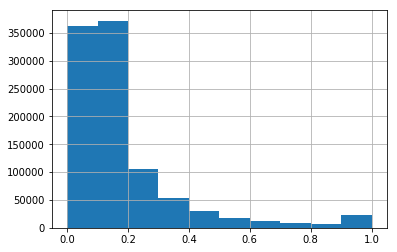

In [91]:
prediction_test_df['deal_probability'].hist()

## Using SVR

In [20]:
from sklearn.svm import SVR


In [22]:
try:
    description_reduced_countvec_svr_model = load_description_linear_regression_model(
        'description_reduced_countvec_svr_model.pkl')
except:
    description_reduced_countvec_svr_model = SVR(kernel='poly', verbose=True, cache_size=16000)     
    description_reduced_countvec_svr_model.fit(description_vectorized, train_df['deal_probability'])


In [29]:
save_description_linear_regression_model(
    pkl_filename='description_reduced_countvec_svr_model.pkl', 
    model=description_reduced_countvec_svr_model
)

In [27]:
y_predic = description_reduced_countvec_svr_model.predict(description_vectorized_test)
def limit_value(value):
    if value > 1:
        value = 1
    elif value < 0:
        value = 0
    return value
y_treated = np.array(list(map(limit_value, y_predic)))

In [28]:
print(mean_squared_error(test_df['deal_probability'], np.zeros(y_predic.shape)))
print(mean_squared_error(test_df['deal_probability'], y_treated))

0.08696623321357727
0.06911413911149261


# Running on test.csv for submission

In [32]:
submission_df = pd.read_csv('test.csv.zip', compression='zip')
submission_df['description'] = submission_df['description'].replace(np.nan, '', regex=True)

In [33]:
submission_df['description_reduced'] = return_description_reduced(submission_df)

0.0


/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.09999842655348341
0.19999685310696683
0.29999527966045025
0.39999370621393365
0.49999213276741705
0.5999905593209005
0.6999889858743839
0.7999874124278673
0.8999858389813508
0.9999842655348341


In [34]:
description_vectorized_submission = vectorizer_description.transform(submission_df['description_reduced'])

### linear regression

In [46]:
y_predic = desc_red_countvec_lreg_model.predict(description_vectorized_submission)

### svr

In [35]:
y_predic = description_reduced_countvec_svr_model.predict(description_vectorized_submission)

### post-processing

In [53]:
min_y_predic = min(y_predic)
max_y_predic = max(y_predic)

y_predic_normalized = (y_predic-min_y_predic)/(max_y_predic-min_y_predic)

In [36]:
def limit_value(value):
    if value > 1:
        value = 1
    elif value < 0:
        value = 0
    return value
y_treated = np.array(list(map(limit_value, y_predic)))


In [40]:
submission_prediction_df = pd.DataFrame(
    {'deal_probability': y_predic}, 
    index=submission_df['item_id'])

In [41]:
submission_prediction_df.head()

,deal_probability
item_id,
6544e41a8817,0.100465
65b9484d670f,0.100465
8bab230b2ecd,0.100465
8e348601fefc,0.100465
8bd2fe400b89,0.100465


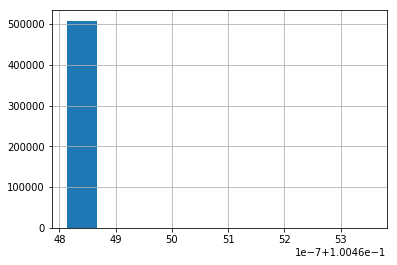

In [42]:
submission_prediction_df['deal_probability'].hist()

In [43]:
submission_prediction_df['deal_probability'].describe()

count    5.084380e+05
mean     1.004648e-01
std      1.544080e-09
min      1.004648e-01
25%      1.004648e-01
50%      1.004648e-01
75%      1.004648e-01
max      1.004654e-01
Name: deal_probability, dtype: float64

In [44]:
submission_prediction_df.to_csv('submission_svr.csv')

# salvando csv do description reduced

In [47]:
train_df['description_reduced'].to_csv('train_df_description_reduced.csv')

In [48]:
test_df['description_reduced'].to_csv('train_test_df_description_reduced.csv')